In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

In [4]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions



In [5]:
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [9]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations

,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-03-16,02,Alaska,8,1.124502
1,2,2024-03-16,01,Alabama,81,1.599596
2,3,2024-03-16,05,Arkansas,188,6.180393
3,4,2024-03-16,04,Arizona,134,1.825360
4,5,2024-03-16,06,California,185,0.475743
...,...,...,...,...,...,...
5825,5826,2022-02-12,50,Vermont,0,0.000000
5826,5827,2022-02-12,53,Washington,8,0.103415
5827,5828,2022-02-12,55,Wisconsin,29,0.492275
5828,5829,2022-02-12,54,West Virginia,5,0.281694


In [16]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4

target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations

,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-03-16,02,Alaska,8,1.124502
1,2,2024-03-16,01,Alabama,81,1.599596
2,3,2024-03-16,05,Arkansas,188,6.180393
3,4,2024-03-16,04,Arizona,134,1.825360
4,5,2024-03-16,06,California,185,0.475743
...,...,...,...,...,...,...
5825,5826,2022-02-12,50,Vermont,0,0.000000
5826,5827,2022-02-12,53,Washington,8,0.103415
5827,5828,2022-02-12,55,Wisconsin,29,0.492275
5828,5829,2022-02-12,54,West Virginia,5,0.281694


In [114]:
# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']
target = 'hosp'
loc = 'US'

if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()

i=1
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    df['Model'] = model
    df = df[df.location==loc]
    
    for scenario in ['F-2023-08-14']:
        for run in df.output_type_id.unique():
    
            df1 = df[(df.scenario_id==scenario) & (df.output_type_id==run)]

            df1['trajectory_id'] = i


            predictionsall = pd.concat([predictionsall, df1])

            i+=1

    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]  

it=[]

for its in range(500):

    samp = random.sample(list(predictionsall.trajectory_id.unique()), 10)
    it.append(samp)

    predictionsfilt = predictionsall[(predictionsall.location == loc) & \
                                (predictionsall.target == 'inc ' + target)  & \
                                (predictionsall.target_end_date <= max_date) & \
                                (predictionsall.target_end_date >= start_week) &\
                                (predictionsall.trajectory_id.isin(samp))]

    # get observations
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]   

    #filter location
    observations = observations[observations['location'] == loc]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)


    y = np.array(observations.value)
    X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]

    ES = energyscore(np.array(X),y)

    if loc == 'US':
        loc_conv = loc
    elif int(loc) <10:
        loc_conv = loc[1]
    else:
        loc_conv = loc  

    newrow = pd.DataFrame({'location':loc_conv,  
                        'target':target, 'energyscore': ES}, index=[0])

    energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   




In [103]:
energyscoresdf

,location,target,energyscore
0,US,hosp,17859.614754
1,US,hosp,15259.048858
2,US,hosp,15065.917737
3,US,hosp,16195.207647
4,US,hosp,17954.257547
...,...,...,...
495,US,hosp,14369.580513
496,US,hosp,16718.083688
497,US,hosp,15518.199325
498,US,hosp,15781.759381


In [115]:
energyscoresdf = energyscoresdf.sort_values(by=['energyscore'])


In [116]:
energyscores_best = energyscoresdf.head(10)

In [117]:
energyscores_best.index

Int64Index([294, 187, 488, 333, 440, 386, 432, 86, 434, 208], dtype='int64')

In [118]:
besttraj = []

for i in energyscores_best.index:
    besttraj+=it[i]
    
    
besttraj = list(set(besttraj))

In [119]:
ens = predictionsall[predictionsall.trajectory_id.isin(besttraj)]

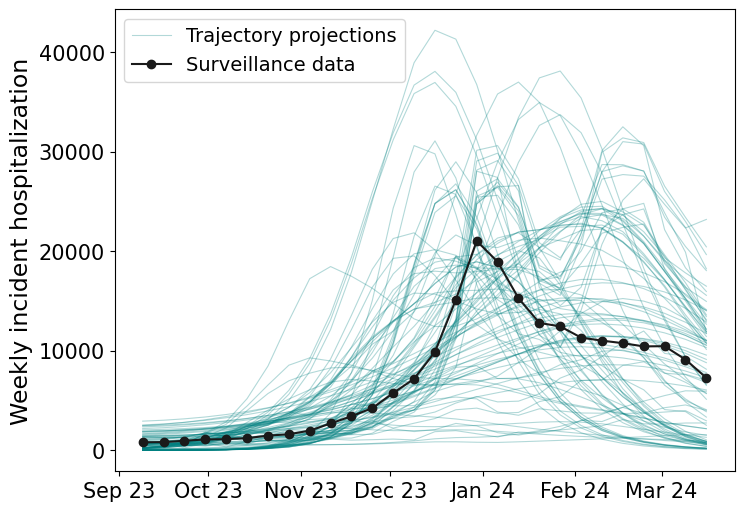

In [128]:
# include all models, even those only submitting for one location
model = 'MOBS_NEU-GLEAM_FLU'

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

   
    
# filter by dates with data
predictions = predictions_traj[(predictions_traj.target_end_date <= max_date) & 
                                (predictions_traj.Model == model)]   

fig, axes = plt.subplots(1,1, figsize=(8,6), sharey=True)


scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    


for traj in ens.trajectory_id.unique():
    p = ens[ens.trajectory_id == traj]
    plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8)
    
plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8, label=fr"Trajectory projections")


observations = format_observations(location=location)

axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
      
set_date_axis_fmt(axes)

plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization", fontsize=17)
plt.legend(loc='upper left', fontsize=14)
axes.tick_params(axis='both', labelsize=15)



#plt.savefig('../trajectory_quantile_format.pdf')
plt.show()

In [121]:
# get observations
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= start_week) & \
                            (observations['date'] <= max_date)]   

#filter location
observations = observations[observations['location'] == loc]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


y = np.array(observations.value)
X = [np.array(ens[ens.trajectory_id == i].value) for i in ens.trajectory_id.unique()]

ES = energyscore(np.array(X),y)


In [122]:
ES

11376.758169280778

In [125]:
es = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_trajensemble_rd4_hosp_214.pkl")
es[(es.location==loc) & (es.Label=='Scenario F')].energyscore

11    11913.81306
Name: energyscore, dtype: float64

In [127]:
ES < list(es[(es.location==loc) & (es.Label=='Scenario F')].energyscore)[0]

True